In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

#### PROVIDE DATA

In [2]:
full_name = 'Dmitry Polovnikov'
random_state = sum(map(ord,full_name))

In [26]:
MLDATA_PATH = 'moex_top.csv'
mldata = pd.read_csv(MLDATA_PATH,index_col=0)
mldata = mldata.fillna(mldata.mean())
mldata = mldata.pct_change()
mldata = mldata.dropna()
# mldata.index = pd.to_datetime(mldata.index)

#### (a) RUN PCA

In [6]:
pca = PCA(n_components=mldata.shape[1])
pca.fit(mldata)

PCA(n_components=78)

In [7]:
transformed = pca.transform(mldata)
transformed = transformed[transformed[:,:2].max(axis=1)<10]

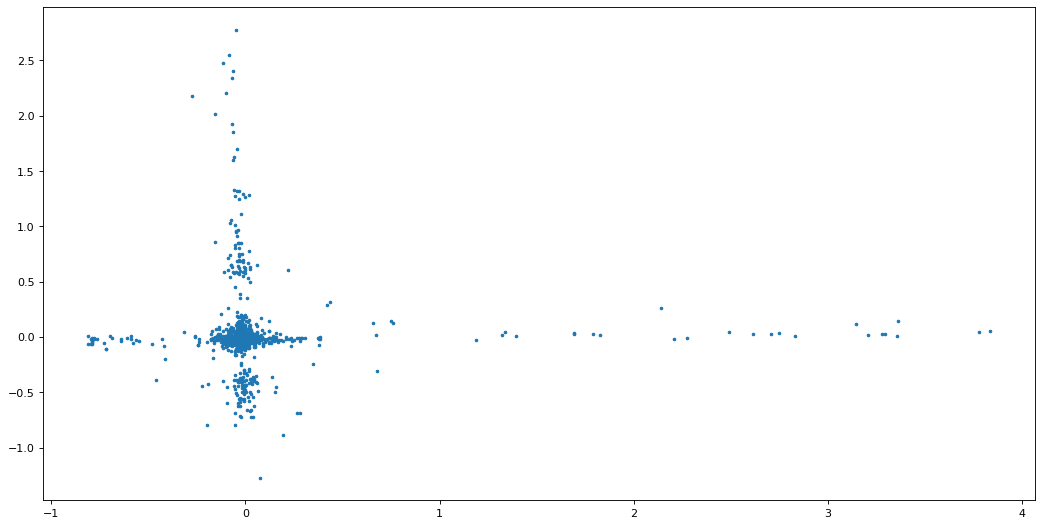

In [8]:
plt.figure(figsize=(16, 8), dpi=80)
plt.scatter(transformed[:,1],transformed[:,2],s=5)

(<matplotlib.legend.Legend at 0x7f3bc4645420>,
 <matplotlib.legend.Legend at 0x7f3bc45ae410>)

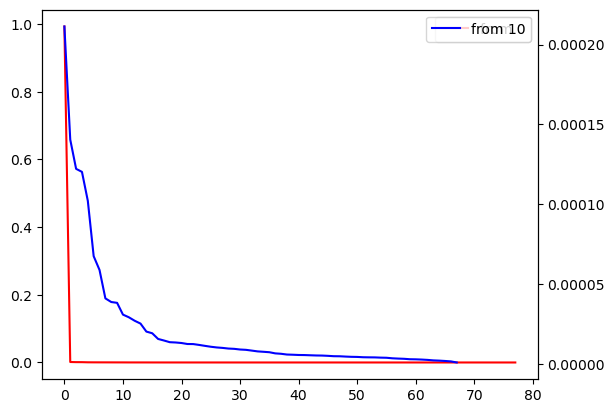

In [9]:
fig, ax1 = plt.subplots()
ax1.plot(pca.explained_variance_ratio_, color='r', label='from 0')
ax2 = ax1.twinx()

ax2.plot(pca.explained_variance_ratio_[10:], color='b', label='from 10')
ax1.legend(), ax2.legend()

#### (b) RUN TSNE

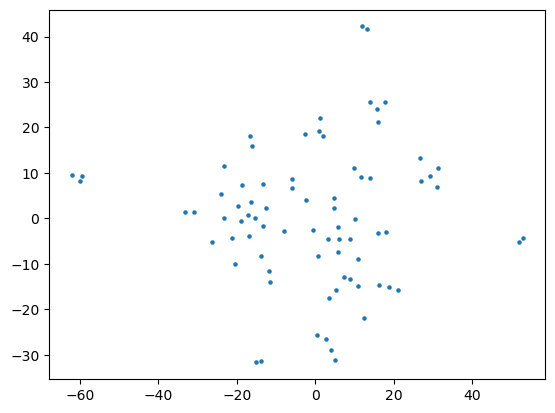

In [10]:
tsne = TSNE(n_components=2, perplexity=2, random_state=random_state)
transformed = tsne.fit_transform(mldata.T)
plt.scatter(transformed[:,0],transformed[:,1],s=5)

#### (c) BONUS

In [11]:
from tqdm.notebook import tqdm

In [12]:
%%time
window = 80
portfolio_dict = {}

for i, d in tqdm(enumerate(mldata.index[window:])):
    pca = PCA(n_components=mldata.shape[1])
    pca.fit(mldata.iloc[i:i + window, :])
    portfolio_dict[d] = pca.components_[-1]

0it [00:00, ?it/s]

CPU times: user 3min 52s, sys: 16min 14s, total: 20min 6s
Wall time: 17.4 s


In [19]:
portfolio_dict_df = pd.DataFrame(
    data=portfolio_dict.values(),
    columns=mldata.columns,
    index=portfolio_dict.keys()
)

In [20]:
def renorm_portfolio(portfolio):
    new_portfolio = deepcopy(portfolio)
    new_portfolio = new_portfolio.sub(new_portfolio.mean(axis=1), 0)
    new_portfolio = new_portfolio.div(new_portfolio.abs().sum(1) + 1e-8, 0)
    return new_portfolio

def get_pnl(portfolio):
    pnl = portfolio.sum(axis=1)
    return pnl.cumsum()

In [27]:
norm_portfolio = renorm_portfolio(portfolio_dict_df)

In [28]:
returns = mldata.shift(-2)

In [29]:
pnl = get_pnl(norm_portfolio * returns)[window:-2]

In [31]:
pnl_diff = pnl.diff()
std = pnl_diff.std()
mean = pnl_diff.mean()
pnl_diff = pnl_diff[pnl_diff.abs() < mean + std*2]

<Axes: >

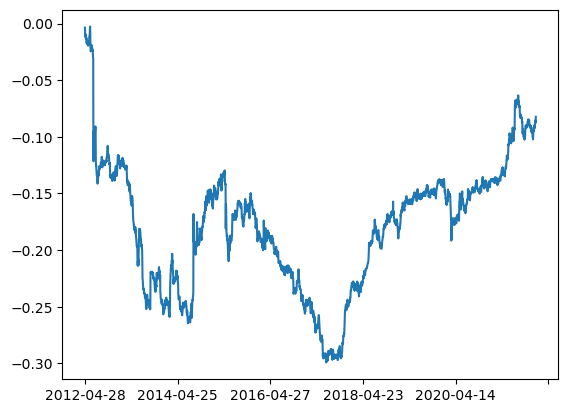

In [32]:
pnl_diff.cumsum().plot()